In [ ]:
# Core code done and provided by Jack.R.

In [58]:
import dwave_networkx as dnx
import networkx as nx
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler
from hybrid.decomposers import _chimeralike_to_zephyr
import numpy as np

import torch

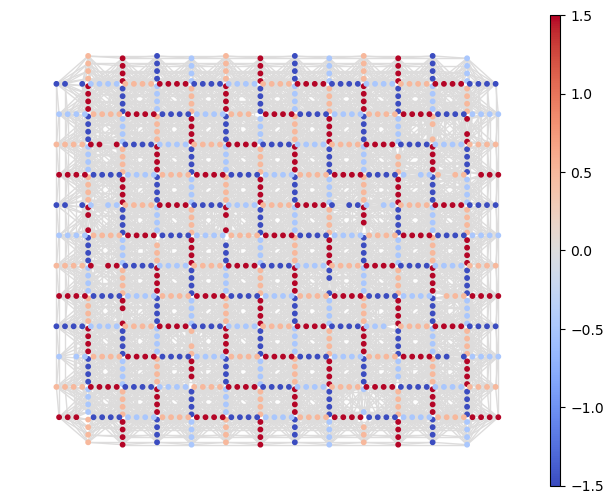

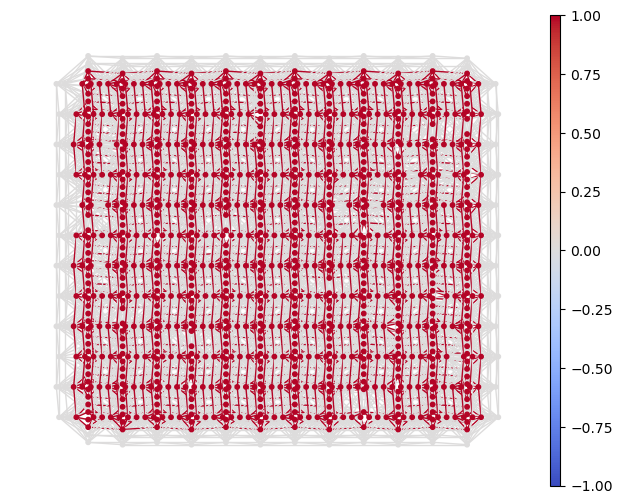

total qubits 1248
max degree 20


In [23]:
#grid parameter: m
#tile parameter: t
online = True
# https://www.dwavequantum.com/media/fawfas04/14-1056a-a_zephyr_topology_of_d-wave_quantum_processors.pdf 
if online:
    qpu = DWaveSampler(solver={'topology__type': 'zephyr'})  # Or specify name
    # qpu = DWaveSampler(solver={'topology__type': 'pegasus'})  # Or specify name
    m, t = qpu.properties['topology']['shape']
    graph = dnx.zephyr_graph(m=m, t=t,
                             node_list=qpu.nodelist, edge_list=qpu.edgelist)
    coordinated_graph = nx.relabel_nodes(
        graph,
        {q: dnx.zephyr_coordinates(m,t).linear_to_zephyr(q)
         for q in graph.nodes})
    # NB, you can relabel back to linear coordinates with zephyr_to_linear.
    node_size = 10
else:
    # Smaller defect free case for visualization, can be executed locally
    m = 2
    t = 4
    # verticals and horizontals are clustered into groups of (t=4), you can
    # get a better understanding by playing with smaller t values
    coordinated_graph = dnx.zephyr_graph(m=m, t=t, coordinates=True)
    node_size = 15
# u, w, k, j, z ; see paper.
coloring = {q : (2*q[0]+q[1] + 2*q[4]+q[3])%4 for q in coordinated_graph.nodes}
assert all(coloring[q1] != coloring[q2] for q1,q2 in coordinated_graph.edges)
color_n = {q : (coloring[q]-1.5) for q in coordinated_graph.nodes} # for contrast, this coloring scheme takes a linear index.
color_e = {e : 0 for e in coordinated_graph.edges}
plt.figure(1)
dnx.draw_zephyr(coordinated_graph,linear_biases=color_n, quadratic_biases=color_e, node_size=node_size)
plt.savefig('/home/javier/Projects/CaloQVAE/figs/DWAVE/figure_zephyr_small.png')

# There are many 'Chimera graphs' as subgraphs of zephyr, here is one example
# that is supported in the code base (I like it because it plays nice with
# default visualizations -- highly symmetric
m_chimera = n_chimera = 2*m
t_chimera = t
graph = dnx.chimera_graph(m_chimera, n_chimera, t_chimera, coordinates=True)
nodes_map = {n: _chimeralike_to_zephyr(n) for n in graph.nodes}
nodes = set(nodes_map.values())
edges = {(nodes_map[n1], nodes_map[n2]) for n1,n2 in graph.edges}
edges = edges | {(n2,n1) for n1,n2 in edges}
# Draw as chimera subgraph:
color_n = {n: int(n in nodes) for n in coordinated_graph.nodes}
color_e = {e: int(e in edges) for e in coordinated_graph.edges}
plt.figure(2)
dnx.draw_zephyr(coordinated_graph, linear_biases=color_n,
                quadratic_biases=color_e,
                node_size=node_size)
plt.savefig('/home/javier/Projects/CaloQVAE/figs/DWAVE/figure_zephyr_small_chim_embedded.png')
plt.show()
print("total qubits", 8*t*m*m + 4*t*m)
print("max degree", 4*(t+1))

In [6]:
def coordinates_to_idx(q, m, t):
    return q[4] + m*(q[3] + 2*(q[2] + t*(q[1]+(2*m+1)*q[0])))

In [7]:
m, t = qpu.properties['topology']['shape']
partition = {"0" : {"coordinates" : [], "indices" : []}, "1" : {"coordinates" : [], "indices" : []}, "2" : {"coordinates" : [], "indices" : []}, "3" : {"coordinates" : [], "indices" : []}}
idx_dict = {"0" : [], "1" : [], "2" : [], "3" : []}
for q in coordinated_graph.nodes:
    _idx = (2*q[0]+q[1] + 2*q[4]+q[3])%4
    # partition[str(_idx)]["coordinates"].append(q)
    idx_dict[str(_idx)].append(coordinates_to_idx(q, m,t))

In [8]:
idx_map = {}
for key in idx_dict.keys():
    idx_map[key] = {idx:i for i, idx in enumerate(idx_dict[key])}

In [12]:
# for i in range(4):
    # print(len(idx_map[str(i)]))
    
# idx_map['0']
idx_dict.keys()

dict_keys(['0', '1', '2', '3'])

In [ ]:
from CaloQVAE.models.rbm import zephyrRBM

In [ ]:
self = zephyrRBM.ZephyrRBM(302,False)

In [ ]:
_weight_mask_dict = {}
for key in self._weight_mask_dict.keys():
    _weight_mask_dict[key] = torch.zeros(self._nodes_per_partition,
                                    self._nodes_per_partition,
                                    requires_grad=False)
    _weight_mask_dict[key].requires_grad = False

In [ ]:
# data = engine.model.prior.weight_dict['01'].sign().abs().sum(dim=1).detach().cpu().numpy()
binwidth = 1.0
data = {}
for key in self.weight_dict.keys():
    # data[key] = engine.model.prior.weight_dict[key].sign().abs().sum(dim=0).detach().cpu().numpy()
    data[key] = self._weight_mask_dict[key].abs().sum(dim=0).detach().cpu().numpy()

In [ ]:
# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
fig.text(0.5, 0.0, 'Couplings', ha='center', fontsize=15)
fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

# Plot data on each subplot
labels, counts = np.unique(data['01'], return_counts=True)
axs[0,0].bar(labels, counts, align='center', color="b", alpha=0.8)
# axs[0, 0].hist(data['01'], bins=np.arange(min(data['01']), max(data['01']) + binwidth, binwidth), histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, align='center')
axs[0,0].grid("True")
axs[0,0].legend(["v to h"], fontsize=18)

labels, counts = np.unique(data['02'], return_counts=True)
axs[0,1].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[0,1].grid("True")
axs[0,1].legend(["v to s"], fontsize=18)

labels, counts = np.unique(data['03'], return_counts=True)
axs[0,2].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[0,2].grid("True")
axs[0,2].legend(["v to t"], fontsize=18)

labels, counts = np.unique(data['12'], return_counts=True)
axs[1,0].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,0].grid("True")
axs[1,0].legend(["h to s"], fontsize=18)

labels, counts = np.unique(data['13'], return_counts=True)
axs[1,1].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,1].grid("True")
axs[1,1].legend(["h to t"], fontsize=18)

labels, counts = np.unique(data['12'], return_counts=True)
axs[1,2].bar(labels, counts, align='center', color="b", alpha=0.9)
axs[1,2].grid("True")
axs[1,2].legend(["s to t"], fontsize=18)

# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")

plt.show()

In [3]:
#############

In [15]:
import h5py
import torch

# Replace 'your_file.h5' with the path to your HDF5 file
# file_path = '/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3_scaled/dataset_2_1.hdf5'
file_path = '/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/dataset_2_1.hdf5'
data_dict = {}
with h5py.File(file_path, 'r') as file:
    print("Keys: %s" % file.keys())
    for key in file.keys():
        data_dict[key] = torch.tensor(file[key][:])
        
    a_group_key = list(file.keys())[0]

    # Get the data
    data = list(file[a_group_key])

Keys: <KeysViewHDF5 ['incident_energies', 'showers']>


In [16]:
d = data_dict["showers"][:20000,:];
e = data_dict["incident_energies"][:20000,:];

In [79]:
# voxel = data_dict["showers"][:,144*10]


# minVal, maxVal = min(voxel.view(-1).numpy()), max(voxel.view(-1).numpy())
# binwidth = (maxVal-minVal)/50

# plt.figure(figsize=(8,6))
# plt.hist(voxel.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, label="Encoded data", alpha=0.7)

# plt.xlabel("voxels", fontsize=15)
# plt.ylabel("PDF", fontsize=15)

# plt.legend(fontsize=18)
# plt.grid("True")
# # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


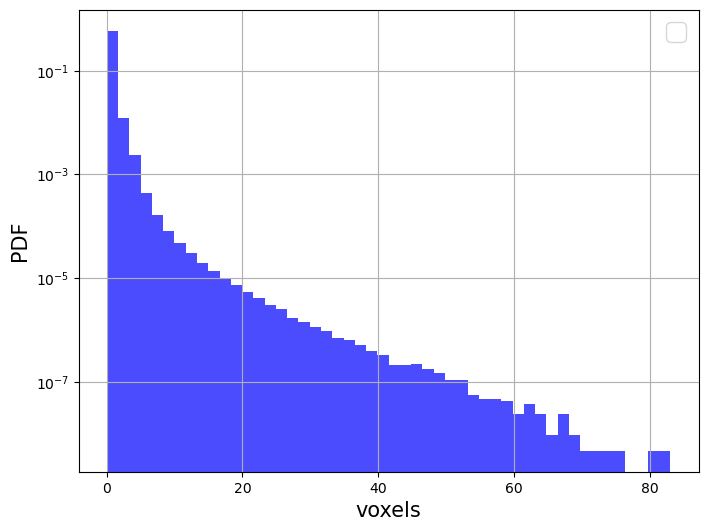

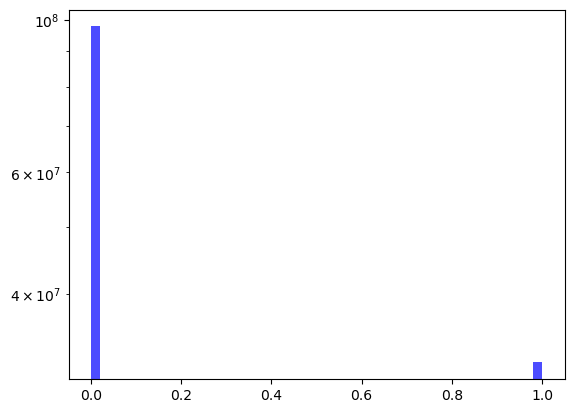

In [14]:
minVal, maxVal = min(d.view(-1).numpy()), max(d.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(d.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

################
dbin = torch.heaviside(d,torch.tensor([0.0]).to(dtype=d.dtype))
minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=False, log=True, label="Encoded data", alpha=0.7)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


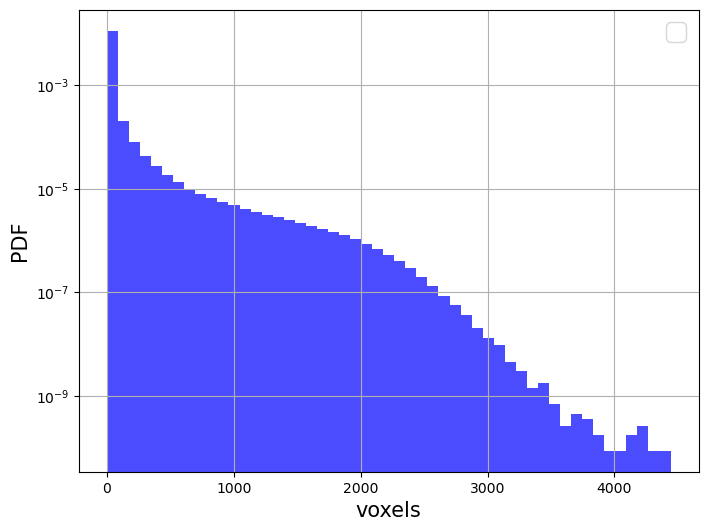

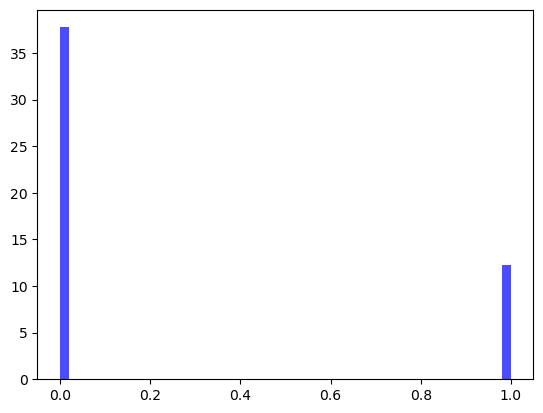

In [24]:
minVal, maxVal = min(d.view(-1).numpy()), max(d.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(d.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
##########################
dbin = torch.heaviside(d,torch.tensor([0.0]).to(dtype=d.dtype))
minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


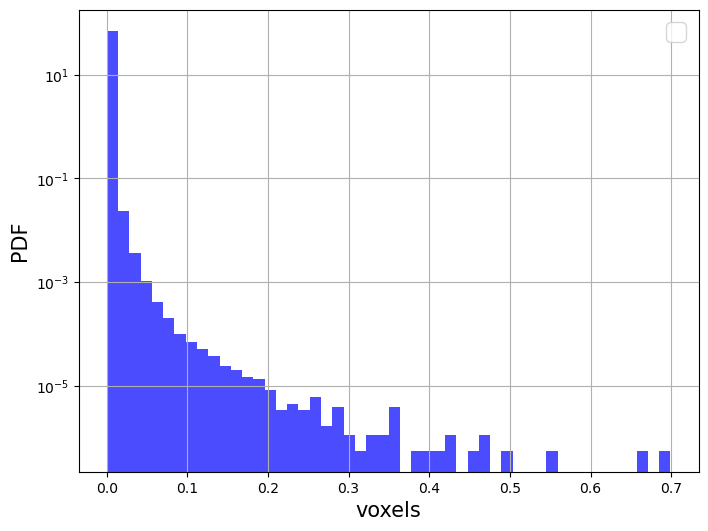

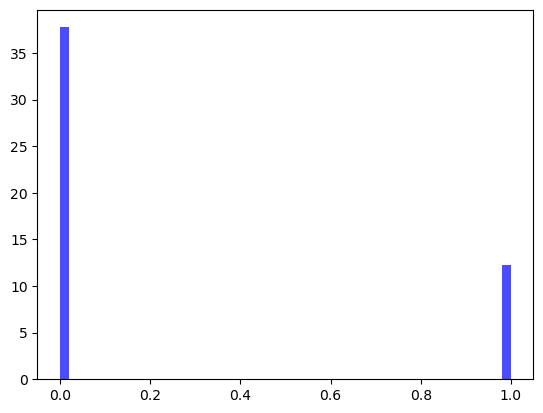

In [25]:
ϵ = d/e
minVal, maxVal = min(ϵ.view(-1).numpy()), max(ϵ.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(ϵ.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

##########################
dbin = torch.heaviside(ϵ, torch.tensor([0.0]).to(dtype=d.dtype))
minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)
plt.show()

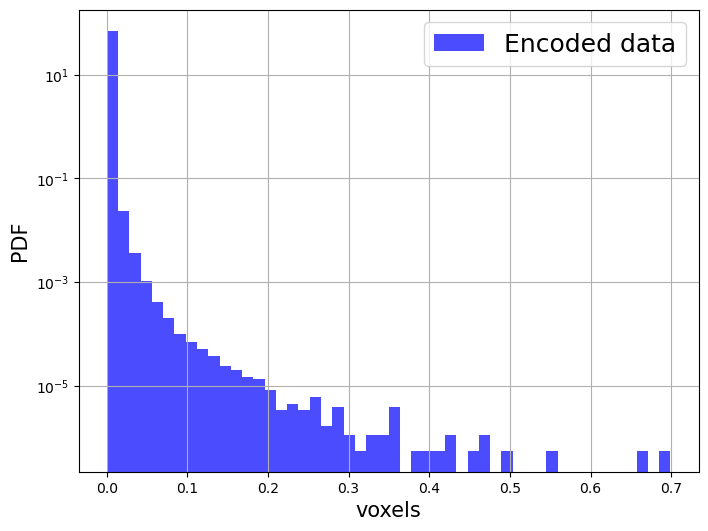

In [31]:
δ=1e-6
x = δ + (1-2*δ)*ϵ
minVal, maxVal = min(x.view(-1).numpy()), max(x.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(x.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, label="Encoded data", alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

##########################
# dbin = torch.heaviside(x, torch.tensor([0.0]).to(dtype=d.dtype))
# minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
# binwidth = (maxVal-minVal)/50
# print(minVal, maxVal, binwidth)

# plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


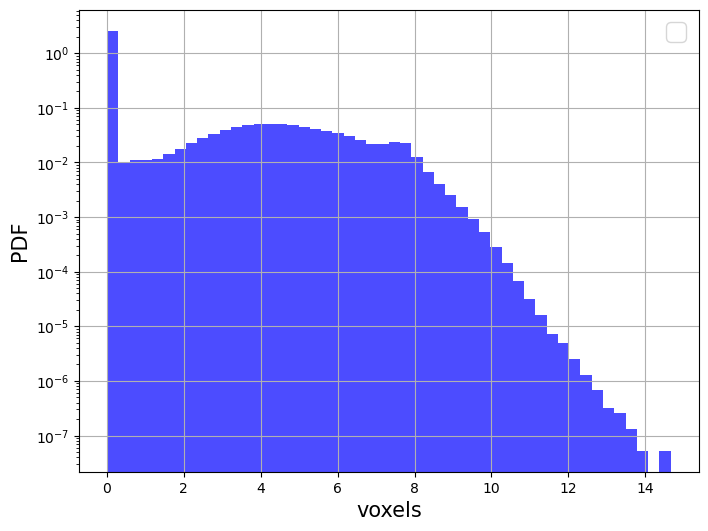

/tmp/ipykernel_1158144/1559851694.py:21: RuntimeWarning: invalid value encountered in double_scalars
  plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)


ValueError: arange: cannot compute length

In [32]:
u = torch.log(x/(1-x)) - torch.log(torch.tensor([δ/(1-δ)]))
minVal, maxVal = min(u.view(-1).numpy()), max(u.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(u.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

##########################
dbin = torch.heaviside(u, torch.tensor([0.0]).to(dtype=d.dtype))
minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)
plt.show()

In [34]:
u.min()

tensor(2.3818e-07, dtype=torch.float64)

In [33]:
dbin = torch.heaviside(u, torch.tensor([0.0]).to(dtype=d.dtype))
minVal, maxVal = min(dbin.view(-1).numpy()), max(dbin.view(-1).numpy())
binwidth = (maxVal-minVal)/50
print(minVal, maxVal, binwidth)

plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)
plt.show()

1.0 1.0 0.0


/tmp/ipykernel_1158144/1365796985.py:6: RuntimeWarning: invalid value encountered in double_scalars
  plt.hist(dbin.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)


ValueError: arange: cannot compute length

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


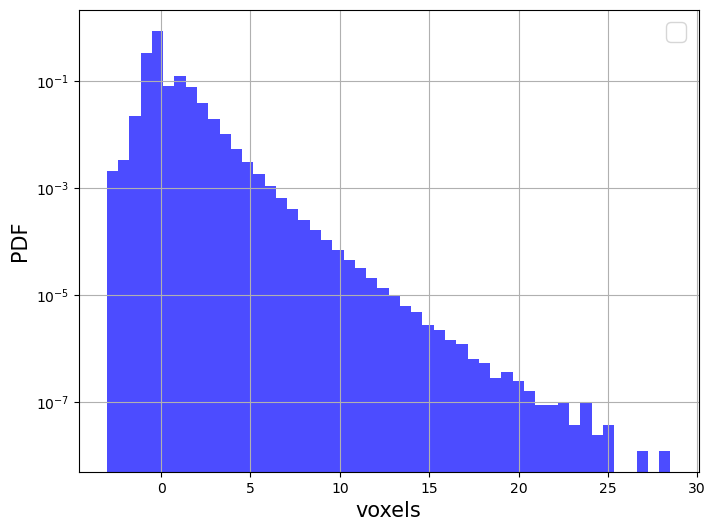

In [29]:
u_prime = (u - u.mean(dim=0))/u.std(dim=0)
minVal, maxVal = min(u_prime.view(-1).numpy()), max(u_prime.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(u_prime.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=True, alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [42]:
u.min()

tensor(-16.1181, dtype=torch.float64)

In [45]:
torch.log(torch.tensor([1e-7]))

tensor([-16.1181])

In [56]:
δ=1e-7
ϵ = d/e
x = δ + (1-2*δ)*ϵ
u = torch.log(x/(1-x)) - torch.log(torch.tensor([δ]))

In [75]:
nn = ((torch.sigmoid(u + torch.log(torch.tensor([δ])) ) - δ)/(1-2*δ) * e)

In [76]:
(nn == 0).sum()
nn[torch.isclose(nn, torch.tensor([0]).to(dtype=nn.dtype, device=nn.device)) ] = 0.0

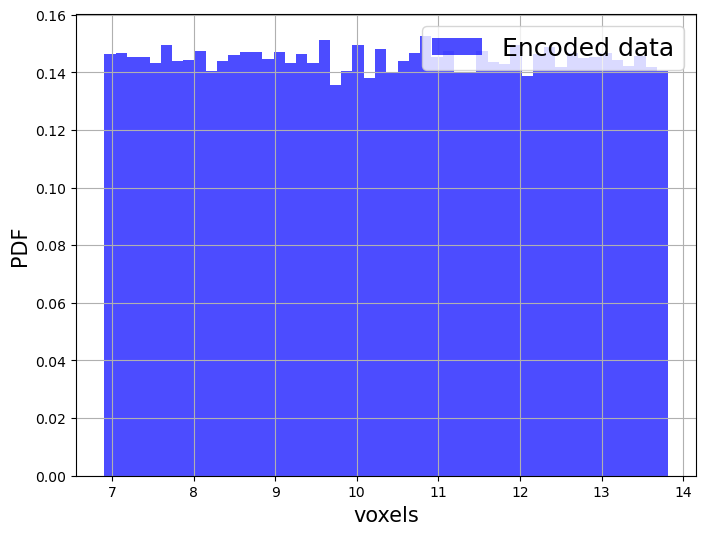

In [46]:
ϵ = torch.log(e)
minVal, maxVal = min(ϵ.view(-1).numpy()), max(ϵ.view(-1).numpy())
binwidth = (maxVal-minVal)/50

plt.figure(figsize=(8,6))
plt.hist(ϵ.view(-1).numpy(), bins=np.arange(minVal, maxVal + binwidth, binwidth), linewidth=2.5, color="b", density=True, log=False, label="Encoded data", alpha=0.7)

plt.xlabel("voxels", fontsize=15)
plt.ylabel("PDF", fontsize=15)

plt.legend(fontsize=18)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_energy_2_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [49]:
ϵ.min()

tensor(6.9083, dtype=torch.float64)

In [50]:
ϵ.max()

tensor(13.8153, dtype=torch.float64)

In [ ]:
new_inc_energy = (log(inc_energy) - min(log(inc_energy)))/(max(log(inc_energy) - min(log(inc_energy)))
                                                           (log(inc_energy) - 6.9)/(13.9 - 6.9)

In [82]:
################
%config InlineBackend.figure_format = 'retina'

In [1]:
# QPU timing

In [35]:
def gen_QPU_sample(num_reads=256):
    τQA=20.0/1000
    τRO = 136.18/1000 
    τdelay = 20.58/1000
    τProg = 15.92676
    gen_time = (τQA + τRO + τdelay )*num_reads + τProg
    return gen_time

def time_Temp_est(num_reads=256, apiCalls=5):
    return apiCalls * gen_QPU_sample(num_reads)


In [34]:
# currently, to generate 1 sample, we 1) estimate T, 2) generate sample:
gen1Sample = time_Temp_est() + gen_QPU_sample(1)

#This is independent of batch size, since we always need to estimate T before generating sample. Hence, for 1 epoch
time_1_epoch = (gen1Sample * 80000)/(1000*60*60)
time_1_epoch

7.155335999999999

In [90]:
# Scenario 1 after fix
def gen_QPU_sample_fixed(num_reads=256, τfb=500):
    τQA=20.0/1000
    τRO = 136.18/1000 
    τdelay = 20.58/1000
    τProg = 15.92676
    gen_time = (τQA + τRO + τdelay +τfb/1000 )*num_reads + τProg
    return gen_time

def gen_time_epoch_1(mb_size=128, num_reads=256, apiCalls=5,τfb=500):
    gen1MB = time_Temp_est(num_reads, apiCalls) + gen_QPU_sample_fixed(mb_size, τfb)
    num_of_MB = 80000/mb_size
    time_1_epoch = (gen1MB * num_of_MB)/(1000*60) #minutes
    return time_1_epoch

def gen_time_epoch_1_val(mb_size=128, num_reads=256, apiCalls=5,τfb=500):
    gen1MB = gen_QPU_sample_fixed(mb_size, τfb)
    num_of_MB = 10000/mb_size
    time_1_epoch = (gen1MB * num_of_MB + time_Temp_est(num_reads, apiCalls))/(1000*60) #minutes
    return time_1_epoch
    

In [55]:
#per minibatch
gen1MB = time_Temp_est() + gen_QPU_sample_fixed(128)
time_1_epoch = (gen1MB * 625)/(1000*60)
time_1_epoch

4.254569166666666

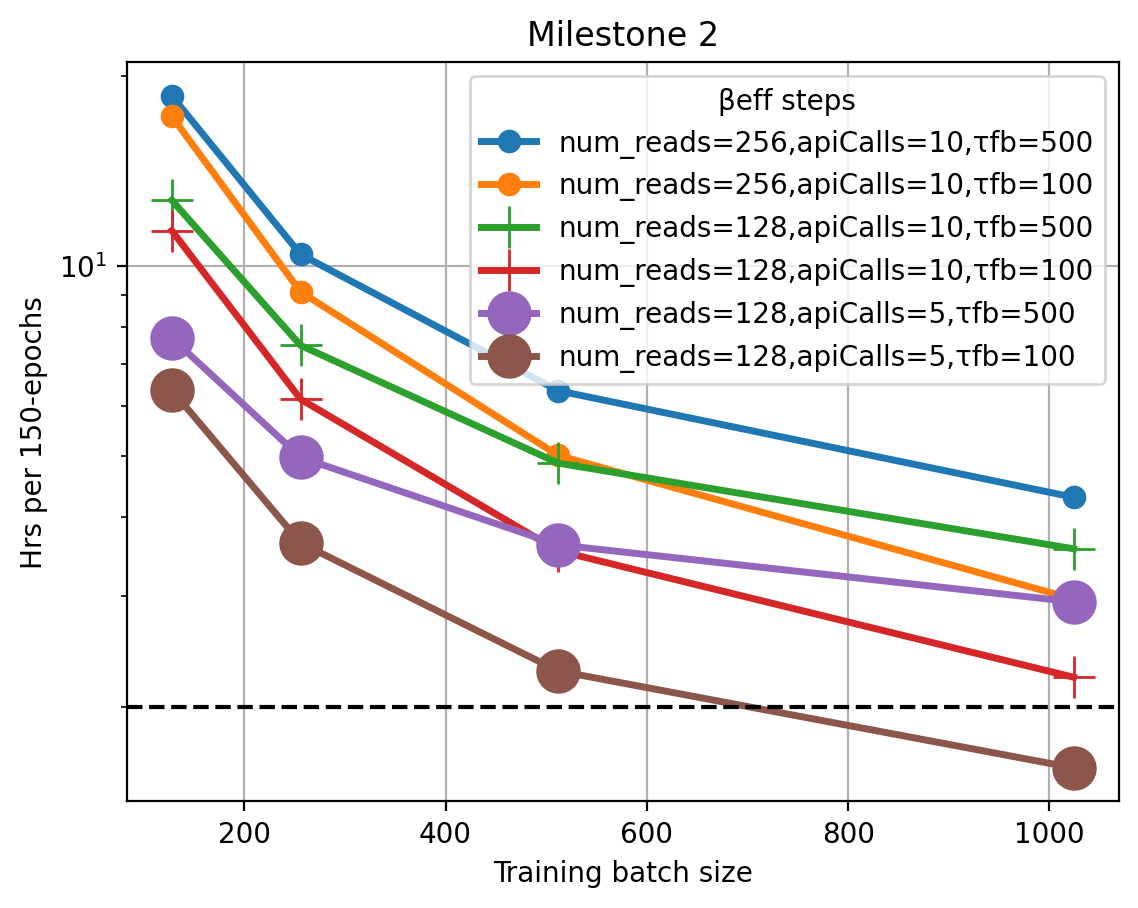

In [83]:
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=256,apiCalls=10,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=256,apiCalls=10,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=128,apiCalls=10,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=128,apiCalls=10,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=128,apiCalls=5,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1(mb_size=i, num_reads=128,apiCalls=5,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)

plt.title("Milestone 2")
plt.xlabel("Training batch size")
plt.ylabel("Hrs per 150-epochs")
plt.legend(["num_reads=256,apiCalls=10,τfb=500","num_reads=256,apiCalls=10,τfb=100",
            "num_reads=128,apiCalls=10,τfb=500","num_reads=128,apiCalls=10,τfb=100",
            "num_reads=128,apiCalls=5,τfb=500","num_reads=128,apiCalls=5,τfb=100"], title="βeff steps")
plt.axhline([2], linestyle="dashed", c='black')
plt.grid("True")
plt.yscale("log")
plt.show()

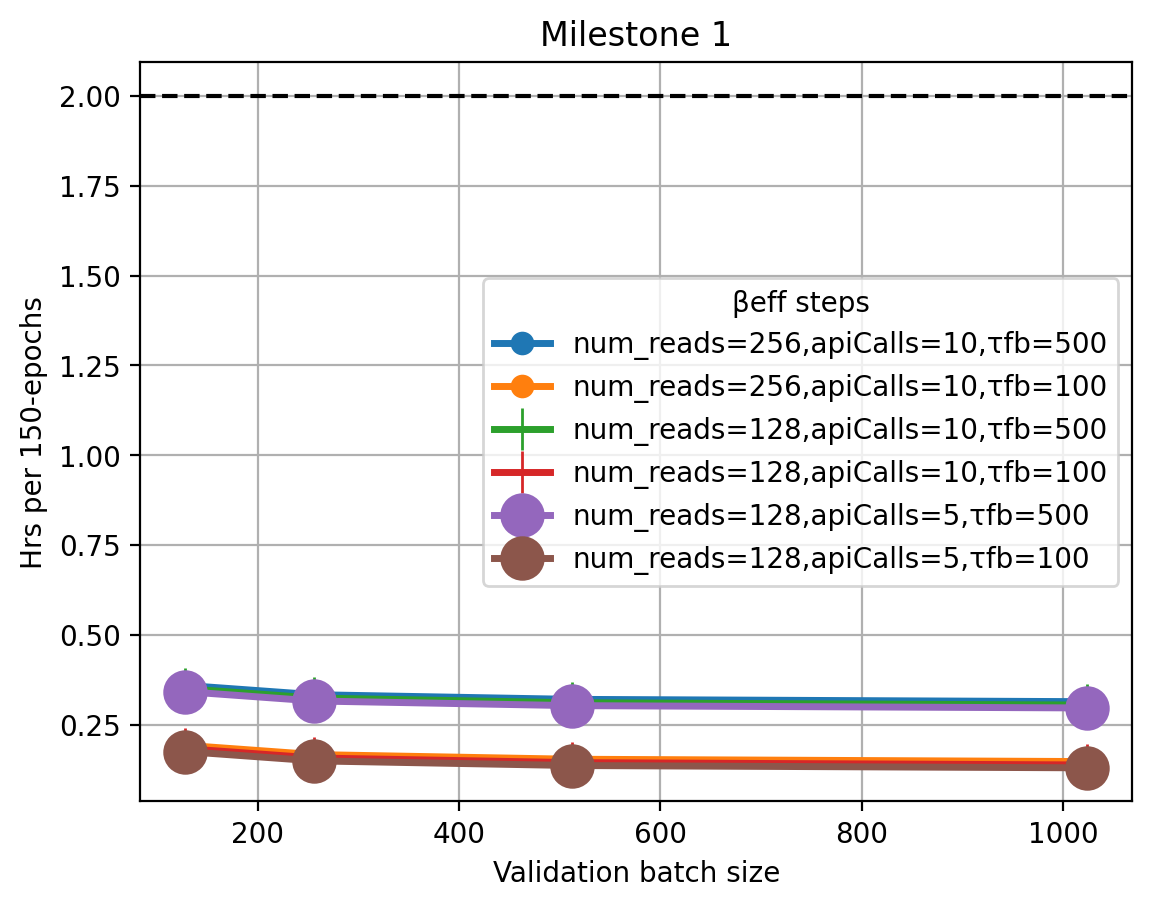

In [92]:
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=256,apiCalls=10,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=256,apiCalls=10,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='.', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=128,apiCalls=10,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=128,apiCalls=10,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='+', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=128,apiCalls=5,τfb=500)*150/60 for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)
plt.plot([128,256,512,1024], [gen_time_epoch_1_val(mb_size=i, num_reads=128,apiCalls=5,τfb=100)*150/60 for i in [128,256,512,1024]],  marker='o', markersize=15, linewidth=2.5)

plt.title("Milestone 1")
plt.xlabel("Validation batch size")
plt.ylabel("Hrs per 150-epochs")
plt.legend(["num_reads=256,apiCalls=10,τfb=500","num_reads=256,apiCalls=10,τfb=100",
            "num_reads=128,apiCalls=10,τfb=500","num_reads=128,apiCalls=10,τfb=100",
            "num_reads=128,apiCalls=5,τfb=500","num_reads=128,apiCalls=5,τfb=100"], title="βeff steps")
plt.axhline([2], linestyle="dashed", c='black')
plt.grid("True")
# plt.yscale("log")
plt.show()